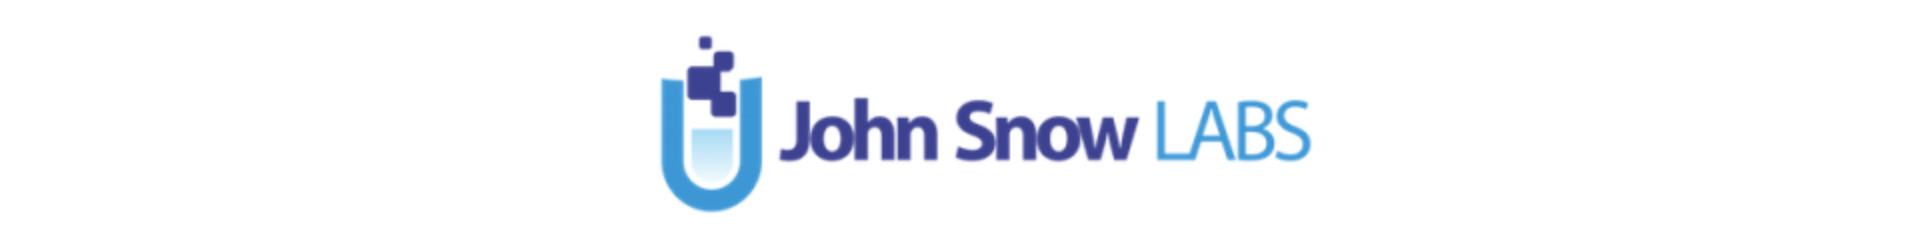

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/tutorials/Certification_Trainings/Public/1.SparkNLP_Basics.ipynb)

# 0. Spark NLP Basics

## 0. Colab Setup

In [0]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.4.5

openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
     |████████████████████████████████| 215.7MB 59kB/s 
     |████████████████████████████████| 204kB 41.9MB/s 
     |████████████████████████████████| 112kB 2.7MB/s 


## 1. Start Spark Session

In [0]:
import sparknlp

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)


Spark NLP version 2.4.5
Apache Spark version: 2.4.4


## 2. Using Pretrained Pipelines

https://github.com/JohnSnowLabs/spark-nlp-models

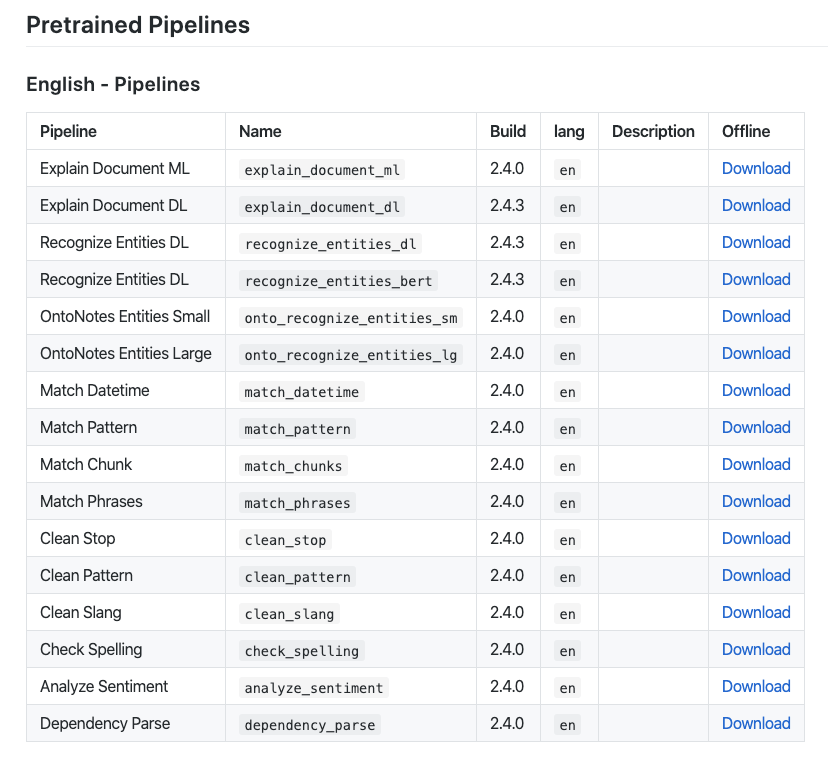

In [0]:
from sparknlp.pretrained import PretrainedPipeline

### Explain Document ML

**Stages**
- DocumentAssembler
- SentenceDetector
- Tokenizer
- Lemmatizer
- Stemmer
- Part of Speech
- SpellChecker (Norvig)




In [0]:
pipeline = PretrainedPipeline('explain_document_ml', lang='en')


explain_document_ml download started this may take some time.
ERROR! Session/line number was not unique in database. History logging moved to new session 59
Approx size to download 9.4 MB
[OK!]


In [0]:
testDoc = '''French author who helped pioner the science-fiction genre. \
Verne wrate about space, air, and underwater travel before navigable aircrast and \
practical submarines were invented, and before any means of space travel had been devised.'''

testDoc

'French author who helped pioner the science-fiction genre. Verne wrate about space, air, and underwater travel before navigable aircrast and practical submarines were invented, and before any means of space travel had been devised.'

In [0]:
%%time

result = pipeline.annotate(testDoc)

CPU times: user 28.8 ms, sys: 6.18 ms, total: 35 ms
Wall time: 128 ms


In [0]:
result.keys()

dict_keys(['document', 'spell', 'pos', 'lemmas', 'token', 'stems', 'sentence'])

In [0]:
result['sentence']

['French author who helped pioner the science-fiction genre.',
 'Verne wrate about space, air, and underwater travel before navigable aircrast and practical submarines were invented, and before any means of space travel had been devised.']

In [0]:
result['token']

['French',
 'author',
 'who',
 'helped',
 'pioner',
 'the',
 'science-fiction',
 'genre',
 '.',
 'Verne',
 'wrate',
 'about',
 'space',
 ',',
 'air',
 ',',
 'and',
 'underwater',
 'travel',
 'before',
 'navigable',
 'aircrast',
 'and',
 'practical',
 'submarines',
 'were',
 'invented',
 ',',
 'and',
 'before',
 'any',
 'means',
 'of',
 'space',
 'travel',
 'had',
 'been',
 'devised',
 '.']

In [0]:
list(zip(result['token'], result['pos']))

[('French', 'JJ'),
 ('author', 'NN'),
 ('who', 'WP'),
 ('helped', 'VBD'),
 ('pioner', 'NN'),
 ('the', 'DT'),
 ('science-fiction', 'NN'),
 ('genre', 'NN'),
 ('.', '.'),
 ('Verne', 'NNP'),
 ('wrate', 'VBD'),
 ('about', 'IN'),
 ('space', 'NN'),
 (',', ','),
 ('air', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('underwater', 'JJ'),
 ('travel', 'NN'),
 ('before', 'IN'),
 ('navigable', 'JJ'),
 ('aircrast', 'NN'),
 ('and', 'CC'),
 ('practical', 'JJ'),
 ('submarines', 'NNS'),
 ('were', 'VBD'),
 ('invented', 'VBN'),
 (',', ','),
 ('and', 'CC'),
 ('before', 'IN'),
 ('any', 'DT'),
 ('means', 'NNS'),
 ('of', 'IN'),
 ('space', 'NN'),
 ('travel', 'NN'),
 ('had', 'VBD'),
 ('been', 'VBN'),
 ('devised', 'VBN'),
 ('.', '.')]

In [0]:
list(zip(result['token'], result['lemmas'], result['stems'], result['spell']))

[('French', 'French', 'french', 'French'),
 ('author', 'author', 'author', 'author'),
 ('who', 'who', 'who', 'who'),
 ('helped', 'help', 'help', 'helped'),
 ('pioner', 'pioneer', 'pioneer', 'pioneer'),
 ('the', 'the', 'the', 'the'),
 ('science-fiction', 'sciencefiction', 'sciencefict', 'sciencefiction'),
 ('genre', 'genre', 'genr', 'genre'),
 ('.', '.', '.', '.'),
 ('Verne', 'Verne', 'vern', 'Verne'),
 ('wrate', 'write', 'wrote', 'wrote'),
 ('about', 'about', 'about', 'about'),
 ('space', 'space', 'space', 'space'),
 (',', ',', ',', ','),
 ('air', 'air', 'air', 'air'),
 (',', ',', ',', ','),
 ('and', 'and', 'and', 'and'),
 ('underwater', 'underwater', 'underwat', 'underwater'),
 ('travel', 'travel', 'travel', 'travel'),
 ('before', 'before', 'befor', 'before'),
 ('navigable', 'navigable', 'navig', 'navigable'),
 ('aircrast', 'aircraft', 'aircraft', 'aircraft'),
 ('and', 'and', 'and', 'and'),
 ('practical', 'practical', 'practic', 'practical'),
 ('submarines', 'submarine', 'submarin', '

In [0]:
 import pandas as pd

 df = pd.DataFrame({'token':result['token'], 
                      'corrected':result['spell'], 'POS':result['pos'],
                      'lemmas':result['lemmas'], 'stems':result['stems']})
df

,token,corrected,POS,lemmas,stems
0,French,French,JJ,French,french
1,author,author,NN,author,author
2,who,who,WP,who,who
3,helped,helped,VBD,help,help
4,pioner,pioneer,NN,pioneer,pioneer
5,the,the,DT,the,the
6,science-fiction,sciencefiction,NN,sciencefiction,sciencefict
7,genre,genre,NN,genre,genr
8,.,.,.,.,.
9,Verne,Verne,NNP,Verne,vern


### Explain Document DL

**Stages**
- DocumentAssembler
- SentenceDetector
- Tokenizer
- NER (NER with GloVe, CoNLL2003 dataset)
- Lemmatizer
- Stemmer
- Part of Speech
- SpellChecker (Norvig)


In [0]:
pipeline_dl = PretrainedPipeline('explain_document_dl', lang='en')


explain_document_dl download started this may take some time.
Approx size to download 168.4 MB
[OK!]


In [0]:
%%time

result = pipeline_dl.annotate(testDoc)

result.keys()

CPU times: user 48.2 ms, sys: 10.3 ms, total: 58.5 ms
Wall time: 862 ms


In [0]:
result.keys()

dict_keys(['entities', 'stem', 'checked', 'lemma', 'document', 'pos', 'token', 'ner', 'embeddings', 'sentence'])

In [0]:
result['entities']

['French', 'Verne']

In [0]:
df = pd.DataFrame({'token':result['token'], 'ner_label':result['ner'],
                      'spell_corrected':result['checked'], 'POS':result['pos'],
                      'lemmas':result['lemma'], 'stems':result['stem']})

df

,token,ner_label,spell_corrected,POS,lemmas,stems
0,French,B-MISC,French,JJ,French,french
1,author,O,author,NN,author,author
2,who,O,who,WP,who,who
3,helped,O,helped,VBD,help,help
4,pioner,O,pioneer,NN,pioneer,pioneer
5,the,O,the,DT,the,the
6,science-fiction,O,sciencefiction,NN,sciencefiction,sciencefict
7,genre,O,genre,NN,genre,genr
8,.,O,.,.,.,.
9,Verne,B-PER,Verne,NNP,Verne,vern


### Spell Checker

In [0]:
spell_checker = PretrainedPipeline('check_spelling', lang='en')


check_spelling download started this may take some time.
Approx size to download 892.6 KB
[OK!]


In [0]:
result = spell_checker.annotate(testDoc)

result.keys()

dict_keys(['document', 'sentence', 'token', 'checked'])

In [0]:
list(zip(result['token'], result['checked']))

[('French', 'French'),
 ('author', 'author'),
 ('who', 'who'),
 ('helped', 'helped'),
 ('pioner', 'pioneer'),
 ('the', 'the'),
 ('science-fiction', 'science-fiction'),
 ('genre', 'genre'),
 ('.', '.'),
 ('Verne', 'Vern'),
 ('wrate', 'wrote'),
 ('about', 'about'),
 ('space', 'space'),
 (',', ','),
 ('air', 'air'),
 (',', ','),
 ('and', 'and'),
 ('underwater', 'underwater'),
 ('travel', 'travel'),
 ('before', 'before'),
 ('navigable', 'navigable'),
 ('aircrast', 'aircraft'),
 ('and', 'and'),
 ('practical', 'practical'),
 ('submarines', 'submarines'),
 ('were', 'were'),
 ('invented', 'invented'),
 (',', ','),
 ('and', 'and'),
 ('before', 'before'),
 ('any', 'any'),
 ('means', 'means'),
 ('of', 'of'),
 ('space', 'space'),
 ('travel', 'travel'),
 ('had', 'had'),
 ('been', 'been'),
 ('devised', 'devised'),
 ('.', '.')]

### Parsing a list of texts

In [0]:
testDoc_list = ['French author who helped pioner the science-fiction genre.',
'Verne wrate about space, air, and underwater travel before navigable aircrast',
'Practical submarines were invented, and before any means of space travel had been devised.']

testDoc_list

['French author who helped pioner the science-fiction genre.',
 'Verne wrate about space, air, and underwater travel before navigable aircrast',
 'Practical submarines were invented, and before any means of space travel had been devised.']

In [0]:
result_list = pipeline.annotate(testDoc_list)

len (result_list)

3

In [0]:
result_list[0]

{'document': ['French author who helped pioner the science-fiction genre.'],
 'lemmas': ['French',
  'author',
  'who',
  'help',
  'pioneer',
  'the',
  'sciencefiction',
  'genre',
  '.'],
 'pos': ['JJ', 'NN', 'WP', 'VBD', 'NN', 'DT', 'NN', 'NN', '.'],
 'sentence': ['French author who helped pioner the science-fiction genre.'],
 'spell': ['French',
  'author',
  'who',
  'helped',
  'pioneer',
  'the',
  'sciencefiction',
  'genre',
  '.'],
 'stems': ['french',
  'author',
  'who',
  'help',
  'pioneer',
  'the',
  'sciencefict',
  'genr',
  '.'],
 'token': ['French',
  'author',
  'who',
  'helped',
  'pioner',
  'the',
  'science-fiction',
  'genre',
  '.']}

### Using fullAnnotate to get more details



In [0]:
text = 'Peter Parker is a nice guy and lives in New York'

In [0]:
# pipeline_dl >> explain_document_dl

detailed_result = pipeline_dl.fullAnnotate(text)

In [0]:
detailed_result

[{'checked': [Annotation(token, 0, 4, Peter, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 6, 11, Parker, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 13, 14, is, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 16, 16, a, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 18, 21, nice, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 23, 25, guy, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 27, 29, and, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 31, 35, lives, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 37, 38, in, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 40, 42, New, {'confidence': '1.0', 'sentence': '0'}),
   Annotation(token, 44, 47, York, {'confidence': '1.0', 'sentence': '0'})],
  'document': [Annotation(document, 0, 47, Peter Parker is a nice guy and lives in New York, {})],
  'embeddings': [Annotation(word_embeddings, 0, 4, Peter, {'is

In [0]:
detailed_result[0]['entities']

[Annotation(chunk, 0, 11, Peter Parker, {'entity': 'PER', 'sentence': '0', 'chunk': '0'}),
 Annotation(chunk, 40, 47, New York, {'entity': 'LOC', 'sentence': '0', 'chunk': '1'})]

In [0]:
chunks=[]
entities=[]
for n in detailed_result[0]['entities']:
        
  chunks.append(n.result)
  entities.append(n.metadata['entity']) 
    
df = pd.DataFrame({'chunks':chunks, 'entities':entities})
df    

,chunks,entities
0,Peter Parker,PER
1,New York,LOC


In [0]:
tuples = []

for x,y,z in zip(detailed_result[0]["token"], detailed_result[0]["pos"], detailed_result[0]["ner"]):

  tuples.append((int(x.metadata['sentence']), x.result, x.begin, x.end, y.result, z.result))

df = pd.DataFrame(tuples, columns=['sent_id','token','start','end','pos', 'ner'])

df


,sent_id,token,start,end,pos,ner
0,0,Peter,0,4,NNP,B-PER
1,0,Parker,6,11,NNP,I-PER
2,0,is,13,14,VBZ,O
3,0,a,16,16,DT,O
4,0,nice,18,21,JJ,O
5,0,guy,23,25,NN,O
6,0,and,27,29,CC,O
7,0,lives,31,35,NNS,O
8,0,in,37,38,IN,O
9,0,New,40,42,NNP,B-LOC


ERROR! Session/line number was not unique in database. History logging moved to new session 61


### Use pretrained match_chunk Pipeline for Individual Noun Phrase

**Stages**
- DocumentAssembler
- SentenceDetector
- Tokenizer
- Part of Speech
- Chunker

Pipeline:

- The pipeline uses regex `<DT>?<JJ>*<NN>+`
- which states that whenever the chunk finds an optional determiner (DT) followed by any number of adjectives (JJ) and then a noun (NN) then the Noun Phrase(NP) chunk should be formed.

In [0]:
pipeline = PretrainedPipeline('match_chunks', lang='en')


match_chunks download started this may take some time.
Approx size to download 4.3 MB
[OK!]


In [0]:
result = pipeline.annotate("The book has many chapters") # single noun phrase


In [0]:
result

{'chunk': ['The book'],
 'document': ['The book has many chapters'],
 'pos': ['DT', 'NN', 'VBZ', 'JJ', 'NNS'],
 'sentence': ['The book has many chapters'],
 'token': ['The', 'book', 'has', 'many', 'chapters']}

In [0]:
result['chunk']

['The book']

In [0]:
result = pipeline.annotate("the little yellow dog barked at the cat") #multiple noune phrases

In [0]:
result

{'chunk': ['the little yellow dog', 'the cat'],
 'document': ['the little yellow dog barked at the cat'],
 'pos': ['DT', 'JJ', 'JJ', 'NN', 'JJ', 'IN', 'DT', 'NN'],
 'sentence': ['the little yellow dog barked at the cat'],
 'token': ['the', 'little', 'yellow', 'dog', 'barked', 'at', 'the', 'cat']}

In [0]:
result['chunk']

['the little yellow dog', 'the cat']

### Extract exact dates from referential date phrases

In [0]:
pipeline = PretrainedPipeline('match_datetime', lang='en')


match_datetime download started this may take some time.
Approx size to download 12.9 KB
[OK!]


In [0]:
result = pipeline.annotate("I saw him yesterday and he told me that he will visit us next week")

result

{'date': ['2020/04/13', '2020/04/05'],
 'document': ['I saw him yesterday and he told me that he will visit us next week'],
 'sentence': ['I saw him yesterday and he told me that he will visit us next week'],
 'token': ['I',
  'saw',
  'him',
  'yesterday',
  'and',
  'he',
  'told',
  'me',
  'that',
  'he',
  'will',
  'visit',
  'us',
  'next',
  'week']}

In [0]:
pipeline.fullAnnotate("I saw him yesterday and he told me that he will visit us next week")

[{'date': [Annotation(date, 57, 65, 2020/04/13, {'sentence': '0'}),
   Annotation(date, 10, 18, 2020/04/05, {'sentence': '0'})],
  'document': [Annotation(document, 0, 65, I saw him yesterday and he told me that he will visit us next week, {})],
  'sentence': [Annotation(document, 0, 65, I saw him yesterday and he told me that he will visit us next week, {'sentence': '0'})],
  'token': [Annotation(token, 0, 0, I, {'sentence': '0'}),
   Annotation(token, 2, 4, saw, {'sentence': '0'}),
   Annotation(token, 6, 8, him, {'sentence': '0'}),
   Annotation(token, 10, 18, yesterday, {'sentence': '0'}),
   Annotation(token, 20, 22, and, {'sentence': '0'}),
   Annotation(token, 24, 25, he, {'sentence': '0'}),
   Annotation(token, 27, 30, told, {'sentence': '0'}),
   Annotation(token, 32, 33, me, {'sentence': '0'}),
   Annotation(token, 35, 38, that, {'sentence': '0'}),
   Annotation(token, 40, 41, he, {'sentence': '0'}),
   Annotation(token, 43, 46, will, {'sentence': '0'}),
   Annotation(token, 

### Sentiment Analysis

In [0]:
pipeline = PretrainedPipeline('analyze_sentiment', lang='en')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [0]:
result = pipeline.annotate("The movie I watched today was not a good one")

result['sentiment']

['negative']